# Collect data

In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
from tqdm import tqdm

# --- 설정값 ---
TOTAL_STEPS = 20000
ENV_ID = 'ALE/MontezumaRevenge-v5'

print(f"'{ENV_ID}' 환경에서 총 {TOTAL_STEPS} 스텝의 데이터를 수집합니다.")

# --- 환경 초기화 ---
env = gym.make(ENV_ID, render_mode='rgb_array')

# --- 데이터를 종류별로 저장할 리스트 생성 ---
obs_buffer = []
action_buffer = []
reward_buffer = []
terminated_buffer = []
truncated_buffer = []

observation, info = env.reset()

for _ in tqdm(range(TOTAL_STEPS)):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    
    # 각 리스트에 데이터 추가
    obs_buffer.append(observation)
    action_buffer.append(action)
    reward_buffer.append(reward)
    terminated_buffer.append(terminated)
    truncated_buffer.append(truncated)
    
    if terminated or truncated:
        observation, info = env.reset()
    else:
        observation = next_observation

env.close()
print(f"\n데이터 수집 완료! 총 {len(obs_buffer)}개의 경험을 저장했습니다.")

# --- 압축된 .npz 파일로 저장 ---
np.savez_compressed(
    'data/montezuma_data1.npz',  # 파일 이름
    observations=np.array(obs_buffer, dtype=np.uint8),
    actions=np.array(action_buffer, dtype=np.int8),
    rewards=np.array(reward_buffer, dtype=np.float32),
    terminateds=np.array(terminated_buffer, dtype=np.bool_),
    truncateds=np.array(truncated_buffer, dtype=np.bool_)
)

print("✅ 'montezuma_data1.npz' 파일로 데이터 저장을 완료했습니다.")

In [8]:
import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']

# VAE train

In [2]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss
from parts.controller import controller
from tqdm.auto import tqdm

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

observations = CustomImageDataset(data=observations, transform=resize)

dataloader = DataLoader(dataset=observations, batch_size=512)

optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

def vae_train(vae, optimizer, dataloader, epochs=10):
    vae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in tqdm(enumerate(dataloader)):
            data = data.to('cuda:0')
            _, recon_image, mu, logvar = vae(data)

            loss = vae_loss_function(recon_image, data, mu, logvar, beta=1)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
        
        print(f'Epoch {epoch}, Everage loss: {total_loss/len(dataloader):.6f}')

vae_train(vae, optimizer, dataloader, epochs=10)


/home/jovyan/world_model/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
40it [00:04,  9.08it/s]


Epoch 0, Everage loss: 8505.401709


40it [00:03, 10.32it/s]


Epoch 1, Everage loss: 8392.880701


40it [00:03, 10.39it/s]


Epoch 2, Everage loss: 6667.244287


40it [00:03, 10.38it/s]


Epoch 3, Everage loss: 4835.549268


40it [00:03, 10.33it/s]


Epoch 4, Everage loss: 4151.997900


40it [00:03, 10.30it/s]


Epoch 5, Everage loss: 3850.192230


40it [00:03, 10.31it/s]


Epoch 6, Everage loss: 3585.904987


40it [00:03, 10.30it/s]


Epoch 7, Everage loss: 3304.241467


40it [00:03, 10.35it/s]


Epoch 8, Everage loss: 3100.706262


40it [00:03, 10.39it/s]

Epoch 9, Everage loss: 2939.249133


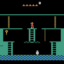

In [3]:
to_pil = transforms.ToPILImage()
to_pil(observations[0])

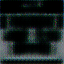

In [4]:
# latent_size 256, beta=0.2
vae.eval()
data = observations[10044].unsqueeze(0).to("cuda:0")
hidden_state, recon_image, _, _ = vae(data)
to_pil(recon_image[0])

In [ ]:
torch.save(vae.state_dict(), 'model_weights/vae_weights.pth')

# MDN_RNN train

In [1]:
import torch
from parts.VAE_CNN import VAE
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
vae.eval()
import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']

In [2]:
from torchvision import transforms

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

import torch
from parts.VAE_CNN import VAE
vae = VAE(input_channel=3, latent_dim=256).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights.pth'))
vae.eval()
import numpy as np
data = np.load('data/montezuma_data1.npz')
observations_raw = data['observations']
actions = data['actions']

In [3]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from tqdm.notebook import tqdm
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, SequenceDataset
import numpy as np

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

mdn_rnn = MDN_RNN(input_size=256, action_size=action_size).to('cuda:0')

seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, action_dataset=action_onehot, sequence_length=1000)
dataloader = DataLoader(dataset=seq_dataset, batch_size=48, num_workers=16)

optimizer = optim.AdamW(mdn_rnn.parameters(), lr=1e-4)

def rnn_train(model=mdn_rnn, dataloader=dataloader, optimizer=optimizer, epochs=10):
    model.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (image, action) in enumerate(tqdm(dataloader, desc=f'epoch: {epoch+1}')):
            image, action = image.to('cuda:0'), action.to('cuda:0')
            with torch.no_grad():
                # have to reshape image vector because vae(cnn) input shape is (batch_size, channel_size, height, width)
                batch, sequence, C, H, W = image.size()
                reshape_images = image.view(-1, C, H, W)
                z_vectors_flatten, _, _, _ = vae(reshape_images)
                z_vectors = z_vectors_flatten.view(batch, sequence, -1)
                
            mu, sigma, phi = model(z_vectors, action)

            batch, sequence, num_dist, latent_size = mu.size()

            mu_pred = mu[: , :-1, :].reshape(-1, num_dist, latent_size)
            sigma_pred = sigma[: , :-1, :].reshape(-1, num_dist, latent_size)
            phi_pred = phi[: , :-1, :].reshape(-1, num_dist)
            target_z =  z_vectors[: , 1:, :].reshape(-1, latent_size)

            loss = mdn_rnn_loss(mu_pred, sigma_pred, phi_pred, target_z)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (batch_idx + 1) % 100 == 0:
                print(f"loss {total_loss / (batch_idx + 1)}")

        print(f"epoch: {epoch+1}, Everage loss: {total_loss/len(dataloader):.6f}")

rnn_train()

epoch: 1:   0%|          | 0/396 [00:00<?, ?it/s]

loss 368.72986694335935


KeyboardInterrupt: 